# GAN

can reference [here](https://github.com/KUASWoodyLIN/TF2-WGAN/blob/master/train.py)

and [here](https://github.com/timsainb/tensorflow2-generative-models/blob/master/3.0-WGAN-GP-fashion-mnist.ipynb)

[here](https://github.com/HCMY/TF2-GAN/blob/master/implementations/wgan/wgan.py)

Keywords :
1. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.constraints import Constraint
from tensorflow.keras import layers
from tensorflow.keras import Model
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm
from pathlib import Path
import time
import PIL
from IPython import display

## A. Data Loading and Plotting

In [2]:
# AnimeDataset: (96, 96, 3)
# extra_data: (64, 64, 3)
imgRootPath = Path('./dataset')
BSIZE = 32

In [3]:
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [64, 64])
    image = (image-0.5)*2.0
    return image

In [4]:
# all images 70171
train_dataset = tf.data.Dataset.list_files(str(imgRootPath/'**/*.jpg')).shuffle(buffer_size=1000)\
                    .map(parse_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                    .batch(BSIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

(32, 64, 64, 3)


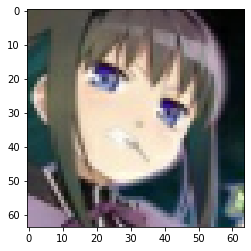

In [5]:
for images in train_dataset:
    plt.imshow(images[0].numpy()/2.0 + 0.5)
    print(images.shape)
    break

In [6]:
for images in train_dataset:
    print(np.max(images[0].numpy()))
    print(np.min(images[0].numpy()))
    break

1.0
-1.0


## Define Generator and Discriminator

In [7]:
def Generator(input_shape=(1, 1, 100), name='Generator'):
    inputs = keras.Input(shape=input_shape)

    # 1: 1x1 -> 4x4
    x = keras.layers.Conv2DTranspose(512, 4, strides=1, padding='valid', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)

    # 2: 4x4 -> 8x8
    x = keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    # 3: 8x8 -> 16x16
    x = keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    # 4: 16x16 -> 32x32
    x = keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    # 5: 32x32 -> 64x64
    x = keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', use_bias=False)(x)
    outputs = keras.layers.Activation('tanh')(x)
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

In [8]:
generator = Generator()

In [9]:
generator.build(input_shape=(None,100))
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1, 100)]       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097152   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0 

In [10]:
def Discriminator(input_shape=(64, 64, 3), name='Discriminator'):
    inputs = keras.Input(shape=input_shape)

    # 1: 64x64 -> 32x32
    x = keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = keras.layers.LeakyReLU()(x)
    # 2: 32x32 -> 16x16
    x = keras.layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    # 3: 16x16 -> 8x8
    x = keras.layers.Conv2D(256, 4, strides=2, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    # 4: 8x8 -> 4x4
    x = keras.layers.Conv2D(512, 4, strides=2, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    # 5: 4x4 -> 1x1
    outputs = keras.layers.Conv2D(1, 4, strides=1, padding='valid')(x)
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

In [11]:
discriminator = Discriminator()

In [12]:
discriminator.build(input_shape=(None,64,64,3))
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131072    
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)       

## Define the loss and optimizers

\begin{align}
\min_G{\max_D{V(D,G)}}=E_{x\sim p_{\text{data}}(x)}\left[\log D(x)\right]+E_{z\sim p_z(x)}\left[\log (1-D(G(z)))\right]
\end{align}

In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
# generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
checkpoint_dir = Path('./training_checkpoints')
checkpoint_prefix = str(checkpoint_dir/"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [15]:
NOISE_DIM = 100
D_ITR = 5
EPOCHS = 200
clamp_lower = -0.01
clamp_upper = 0.01
num_examples_to_generate = 16
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, 1, 1, NOISE_DIM])

In [16]:
@tf.function
def train_dis_step(images):
    noise = tf.random.normal([BSIZE, 1, 1, NOISE_DIM])

    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_gen_step():
    noise = tf.random.normal([BSIZE, 1, 1, NOISE_DIM])
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    

In [18]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        counter = 1
        for image_batch in dataset:
            train_dis_step(image_batch)
            ws = discriminator.get_weights()
#             print(ws[-1])
            if counter%D_ITR==0:
                train_gen_step()
            counter += 1

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [19]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i].numpy()/2.0 + 0.5)
        plt.axis('off')

    plt.savefig('out_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

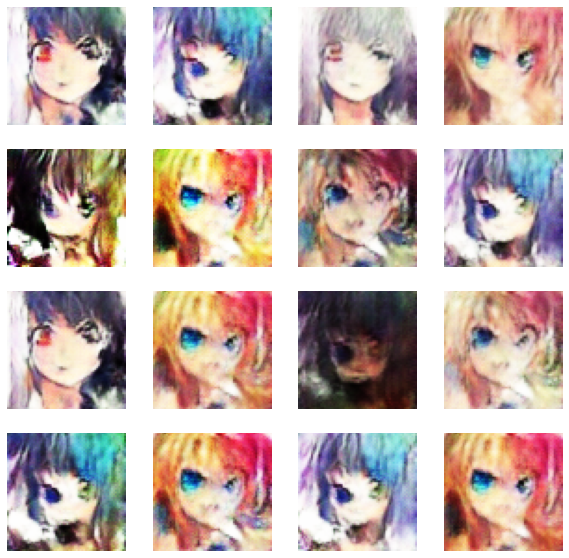

Time for epoch 105 is 112.76795935630798 sec


KeyboardInterrupt: 

In [20]:
train(train_dataset, EPOCHS)

## Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('out_images/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(446)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
import imageio, glob

In [ ]:
anim_file = 'all_rms_wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('out_images/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 10*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [ ]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)

Try generating other images

In [ ]:
codes = np.random.randn(num_examples_to_generate, 1, 1, NOISE_DIM)
predictions = generator(codes, training=False)

fig = plt.figure(figsize=(10,10))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i].numpy()/2.0 + 0.5)
    plt.axis('off')